In [2]:
import numpy as np

from flandre.beamformer.dist import direct_dist
from flandre.beamformer.das import gen_pwi
from flandre.utils.Config import DeviceConfig, ImagingConfig
from flandre.utils.RfMat import RfMat
from flandre.utils.RfMeta import RfFrameMeta, RfSequenceMeta
from flandre.utils.ScanData import ScanData
from pathlib import Path
import scipy
import cv2
import cupy as cp
import cupyx.scipy.fft
from matplotlib import pyplot as plt

/home/lambda/source/scarlet/flandre/.venv/lib/python3.12/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


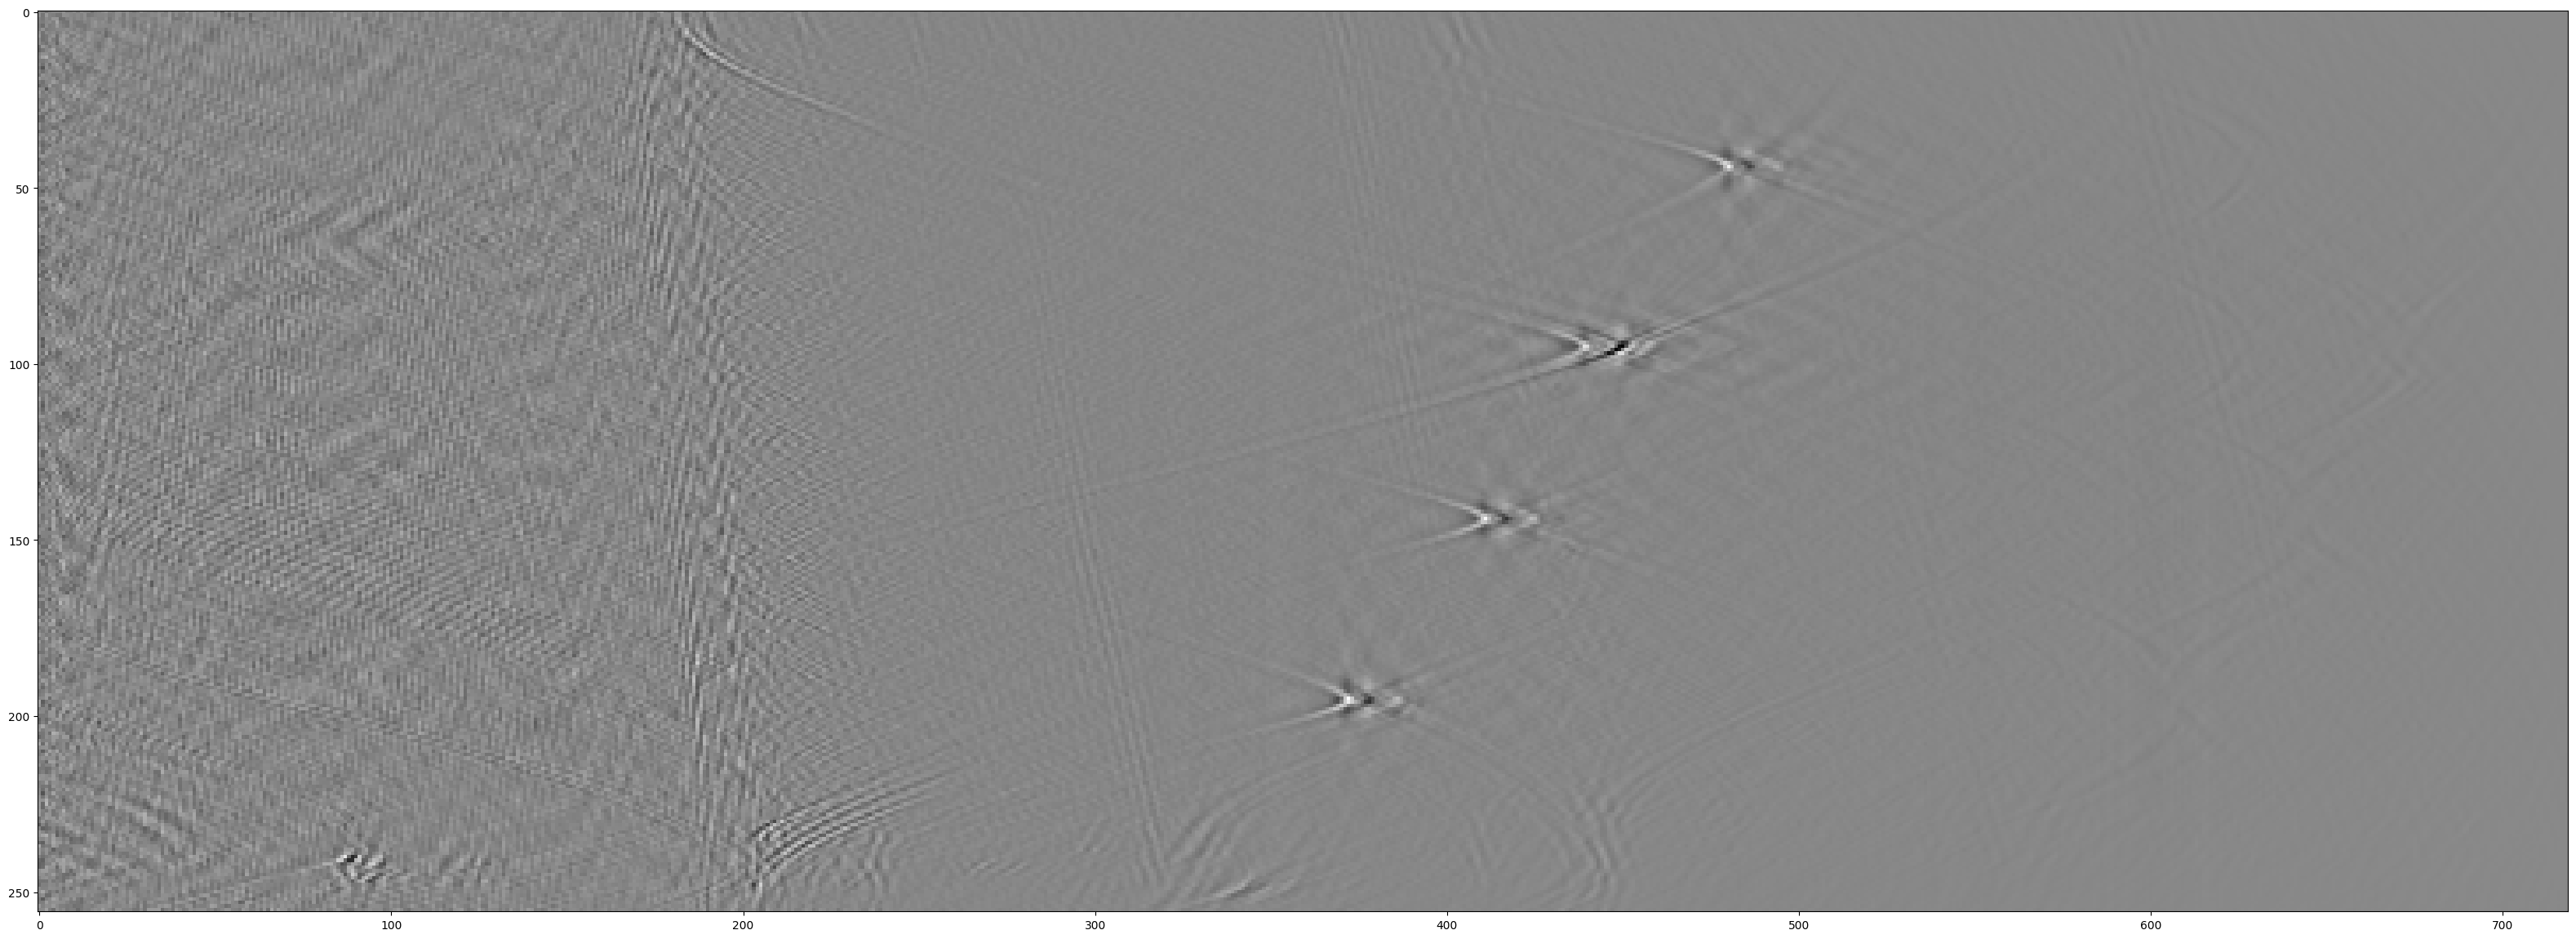

In [7]:

dc = DeviceConfig(v2=1540, rows=1490)
pwi, _ = gen_pwi(direct_dist(dc, p=cp), dc)

input_path = Path('/run/media/lambda/b86dccdc-f134-464b-a310-6575ee9ae85c/uf/cap-30/328_parallel.bin')
input_sd = ScanData.from_file(input_path, (256, 1502), p=cp)
plt.figure(figsize=(40, 20))
dctm = cupyx.scipy.fft.dctn(input_sd.m)
dctm = cupyx.scipy.fft.dctn(input_sd.m)

# dctm[mask[:,:,3]!=0] = 0
dctm[:30, :800] = 0
m2 = cupyx.scipy.fft.idctn(dctm)
input_sd.m = m2

input_sd = input_sd.dct(80, 1500)
# pass.hib().abs().filter_min(300)
plt.imshow(input_sd.m.get()[:, 600:], cmap='grey')
plt.imshow(pwi(input_sd.m).get(), cmap='grey')

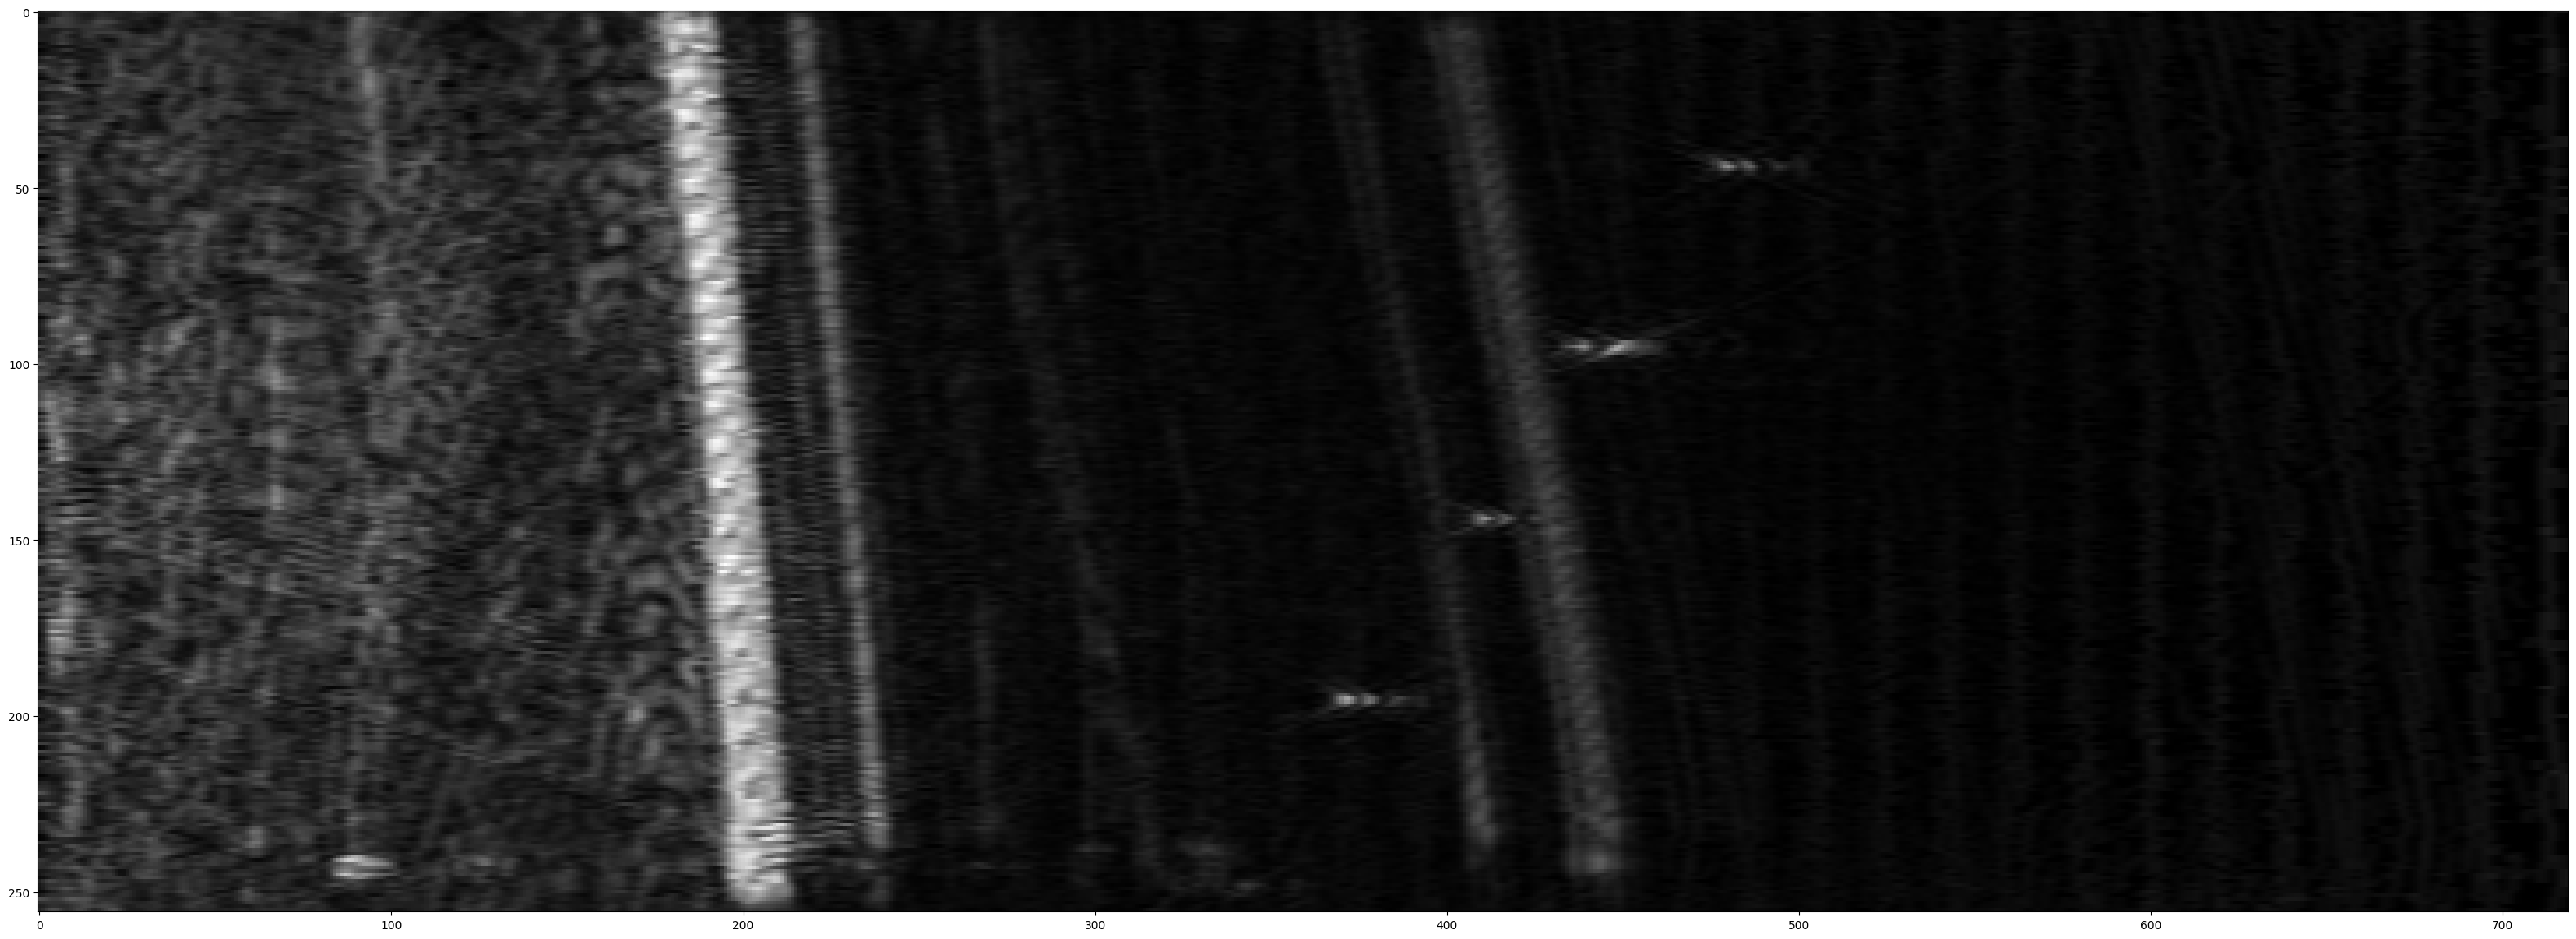

In [19]:
input_path = Path('/run/media/lambda/b86dccdc-f134-464b-a310-6575ee9ae85c/uf/cap-30/328_parallel.bin')
input_bytes = input_path.read_bytes()
mat = np.frombuffer(input_bytes, dtype=np.int16).copy()
mat = mat.reshape((256, 1502))
mat = cp.asarray(mat)

dc = DeviceConfig(v2=1540, rows=1490)
pwi, _ = gen_pwi(direct_dist(dc, p=cp), dc)

rfmat = RfMat(mat, RfFrameMeta(), RfSequenceMeta(shape=(256, 1502)))
rfmat = rfmat.dct(80, 1500)
rfmat = rfmat.call(pwi)
rfmat = rfmat.call(cp.asarray, order='C')
rfmat = rfmat.argrelextrema()
rfmat = rfmat.conv_guass(b=18 * 0.01)
rfmat = rfmat.cpu()

plt.figure(figsize=(40, 20))
plt.imshow(rfmat.m, cmap='grey')



In [3]:
from flandre.utils.RfFile import RfSequence

rff = RfSequence.from_zip(Path('/mnt/16T/private_dataset/us/R1,U=90,M=PWI,S=(256 4502).zip'))

In [10]:
rff.frames[0].data

PosixPath('/mnt/16T/private_dataset/us/R1,U=90,M=PWI,S=(256 4502).zip/0.zst')